## Introduction

L'objectif de ce notebook est d'exposer notre démarche dans la recherche de notre modèle dans le cadre de la prédiction du métier d'un individu selon son CV. Nous avons essayé de comparer différentes méthodes d'apprentissage afin d'avoir le meilleur modèle tout en prennat en compte deux métriques: le f1_score et le score de disparité démographique (disparate impact) moyen.

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

In [2]:
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

In [3]:
# Ce dictionnaire nous servira à construire notre tablea récapituliatif de résultats obtenus à la fin de ce notebook.
summary = {}

In [4]:
#Read our pre-cleaned data from our first round of cleaning

data1 = pd.read_pickle("../../Project_outputs/pickled_files/corpus/round1_cleaned_corpus_for_models.pkl")
# data = data.transpose()
data1.head()

Id                                        description gender  categories
0   0   she is also a ronald d asmus policy entrepren...      F   professor
1   1   he is a member of the aicpa and wicpa brent g...      M  accountant
2   2   dr aster has held teaching and research posit...      M   professor
4   3   he runs a boutique design studio attending cl...      M   architect
5   4   he focuses on cloud security identity and acc...      M   architect

## Classification en utilisant les techniques basiques de pré-traitement et avec Doc2Vec

In [5]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the categories.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [6]:
# Scindons les données:
features = data1.description

#viriable que l'on souhaite prédire
labels1 = data1.categories

In [7]:
jobs = list(labels1.unique())

In [15]:
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train, y_test, indices_train, indices_test = train_test_split(features, labels1, data1.index, test_size=0.33, random_state=0)

In [16]:
X_train_

161948     he has published papers on presentism the pos...
147893     his primary research interests focus on theor...
113918     she graduated with honors in  having more tha...
111252     he is the residentexecutive editor of the jan...
241051     he is also a behavior management coordinator ...
                                ...                        
221542     ms west began her career as corporate attorne...
147555     he has successfully coupled business acumen w...
217453     he has broad interests in laparoscopic colon ...
54411      she received her ba from wellesley college in...
249381     his unique style can be characterized by his ...
Name: description, Length: 145454, dtype: object

In [17]:
X_train = label_sentences(X_train_, 'Train')
X_test = label_sentences(X_test_, 'Test')
all_data = X_train + X_test 

In [18]:
all_data[:2]

[TaggedDocument(words=['he', 'has', 'published', 'papers', 'on', 'presentism', 'the', 'possibility', 'of', 'junk', 'and', 'the', 'history', 'of', 'the', 'liar', 'paradox', 'in', 'medieval', 'arabic', 'logic', 'he', 'is', 'currently', 'working', 'on', 'papers', 'on', 'presentism', 'the', 'history', 'of', 'the', 'liar', 'paradox', 'in', 'medieval', 'arabic', 'logic', 'the', 'nature', 'of', 'possible', 'worlds', 'the', 'ontology', 'of'], tags=['Train_0']),
 TaggedDocument(words=['his', 'primary', 'research', 'interests', 'focus', 'on', 'theoretical', 'and', 'algorithmic', 'issues', 'related', 'to', 'continuous', 'largescale', 'optimization', 'bigdata', 'analytics', 'equilibrium', 'programming', 'and', 'their', 'applications', 'to', 'signal', 'processing', 'communications', 'and', 'machine', 'learning', 'he', 'is', 'an', 'associate', 'editor', 'of', 'the', 'ieee', 'transactions', 'on', 'signal', 'processing'], tags=['Train_1'])]

In [25]:
X_train[0].tags[0]

'Train_0'

In [19]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

4


In [20]:
# initialize the model and train for 30 epochs
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065, workers=cores)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 217097/217097 [00:00<00:00, 961345.22it/s]


In [26]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 217097/217097 [00:00<00:00, 1867228.57it/s]


CPU times: user 24min 7s, sys: 2min, total: 26min 8s
Wall time: 13min 55s


In [30]:
import os
import pickle
filename = "../../Project_outputs/pickled_files/dbow/round1_model_dbow.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pickle.dump(model_dbow, f)

In [31]:
# Get vectors from trained doc2vec model
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [32]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

## Sélection du modèle

Ici, nous allons tenté différents modèles et évaluer leur f1-score.

Les modèles que nous allons tester sont:
- Logistic Regression 
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logreg1 = LogisticRegression(random_state=0, max_iter=2000, multi_class='multinomial')

In [36]:
tps0=time.perf_counter()

logreg1.fit(train_vectors_dbow, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 200.48155359099997


In [37]:
filename = "../../Project_outputs/pickled_files/models/log_reg/doc2vec_model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(logreg1, open(filename, 'wb'))

In [38]:
y_pred_logreg1 = logreg1.predict(test_vectors_dbow)
y_pred_logreg1

array(['attorney', 'professor', 'yoga_teacher', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [39]:
print('accuracy %s' % accuracy_score(y_pred_logreg1, y_test))
print(classification_report(y_test, y_pred_logreg1,target_names=jobs))

accuracy 0.7724969641137306
                   precision    recall  f1-score   support

        professor       0.78      0.68      0.73      1050
       accountant       0.66      0.56      0.61      1918
        architect       0.84      0.87      0.85      6236
     psychologist       0.68      0.55      0.61       467
       journalist       0.72      0.72      0.72       566
          teacher       0.79      0.79      0.79      1161
            nurse       0.87      0.86      0.86      1790
         attorney       0.76      0.79      0.78       750
software_engineer       0.70      0.66      0.68       297
          painter       0.76      0.74      0.75      1344
        physician       0.64      0.55      0.59       282
     chiropractor       0.68      0.72      0.70      4085
 personal_trainer       0.76      0.72      0.74      1397
     photographer       0.82      0.80      0.81      4134
          surgeon       0.74      0.76      0.75      1463
        filmmaker       0.6

In [40]:
logreg1_f1_score = f1_score(y_test, y_pred_logreg1, average='macro')
print('f1_score: %s' % logreg1_f1_score)

f1_score: 0.6964012202959464


In [41]:
cross_logreg1 = pd.crosstab(y_pred_logreg1, y_test, rownames=['Predicted job'], colnames=['Actual job'])
cross_logreg1

Actual job         accountant  architect  attorney  chiropractor  comedian  \
Predicted job                                                                
accountant                717         13        52             0         5   
architect                  18       1083        22             2         2   
attorney                   87         35      5441             8         4   
chiropractor                1          1         4           256         0   
comedian                    5          4         8             0       407   
composer                    0          6         7             0         4   
dentist                     3          2         8             7         2   
dietitian                   4          3         6             5         0   
dj                          1          1         3             0         4   
filmmaker                   1         12        10             0        14   
interior_designer           0         38         3             0         0   
journalist                 42         42       100             1        30   
model                       9          8        15             1        18   
nurse                      10          5        31            16         0   
painter                     3         32         7             0         3   
paralegal                   4          0        42             0         0   
pastor                     11          6        20             0         4   
personal_trainer            2          1         1             5         1   
photographer               15         50        25             3         7   
physician                  11          3        18           114         5   
poet                        2          7        12             1         3   
professor                  62        271       284            15         9   
psychologist                6          4        23            11        11   
rapper                      0          0         0             0        13   
software_engineer           3        259        13             0         2   
surgeon                     2          3         5            14         3   
teacher                    31         29        76             5        15   
yoga_teacher                0          0         0             3         0   

Actual job         composer  dentist  dietitian   dj  filmmaker  ...  \
Predicted job                                                    ...   
accountant                0        4          0    1          0  ...   
architect                 3        5          0    5          5  ...   
attorney                  4        8          3    3         11  ...   
chiropractor              1        3          1    1          1  ...   
comedian                  7        1          0    7         15  ...   
composer                920        1          0   21         20  ...   
dentist                   1     1537          3    0          0  ...   
dietitian                 0        1        591    0          2  ...   
dj                       14        0          0  195          0  ...   
filmmaker                36        1          0    1        991  ...   
interior_designer         0        0          1    0          1  ...   
journalist               10        8         15    9         86  ...   
model                     1        1          2    3          6  ...   
nurse                     0       11         22    0          0  ...   
painter                   9        2          2    3         14  ...   
paralegal                 0        0          0    1          0  ...   
pastor                    4        1          0    0          2  ...   
personal_trainer          1        3         11    0          1  ...   
photographer             20       11          3   11         83  ...   
physician                 2      134         13    0          1  ...   
poet                     19        0          0    0          5  ...   
pro

In [42]:
import seaborn as sns

def plot_heatmap(cross_table, y_label, x_label, fmt='g'):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cross_table,
                annot=None,
                fmt=fmt,
                cmap='magma_r',
                linewidths=.5,
                ax=ax)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()


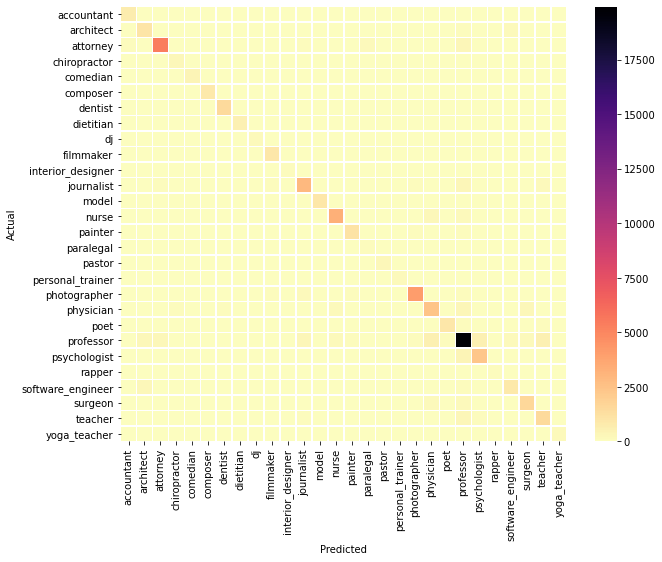

In [43]:
plot_heatmap(cross_logreg1, 'Actual', 'Predicted', fmt='.2%')

In [45]:
y_pred_proba_logreg1 = logreg1.predict_proba(test_vectors_dbow)
y_pred_proba_logreg1

array([[6.19029357e-04, 2.45377507e-05, 8.23442950e-01, ...,
        6.91423720e-05, 9.42914122e-04, 7.14316318e-08],
       [4.52413866e-05, 2.59898317e-05, 1.59610095e-03, ...,
        1.08827939e-03, 4.31830300e-04, 5.61891709e-07],
       [4.52162492e-07, 2.94785981e-06, 2.40720369e-04, ...,
        2.91292404e-04, 1.62068107e-03, 8.54655305e-01],
       ...,
       [1.54010825e-04, 3.42978027e-03, 6.78296727e-03, ...,
        3.62756977e-05, 3.93189916e-03, 1.69442992e-06],
       [1.49534118e-05, 1.06045637e-03, 1.02268893e-05, ...,
        2.27703416e-05, 1.40445720e-01, 2.01130015e-04],
       [4.77988695e-05, 7.44474233e-05, 2.52295983e-03, ...,
        2.54074802e-05, 3.04471309e-03, 1.99466301e-06]])

In [46]:
y_pred_proba_logreg1.shape

(71643, 28)

In [47]:
print("---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: ")
y_pred_proba_logreg1[1]

---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: 


array([4.52413866e-05, 2.59898317e-05, 1.59610095e-03, 7.95368285e-06,
       2.17264716e-09, 5.63767012e-08, 6.22698746e-07, 3.43837302e-03,
       1.71618199e-09, 1.58058321e-07, 2.98380244e-06, 2.23046387e-04,
       5.70611324e-06, 9.91033057e-03, 1.73652966e-05, 9.22843509e-06,
       5.91488534e-07, 9.75039671e-07, 4.87937124e-07, 1.15763065e-01,
       3.95714163e-06, 8.66450456e-01, 9.76132503e-04, 3.08664880e-12,
       5.02523813e-07, 1.08827939e-03, 4.31830300e-04, 5.61891709e-07])

In [48]:
log_reg_pred_prob1 = pd.DataFrame(y_pred_proba_logreg1, columns=logreg1.classes_)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor      comedian  \
0  6.190294e-04   0.000025  0.823443  2.083677e-06  7.062334e-06   
1  4.524139e-05   0.000026  0.001596  7.953683e-06  2.172647e-09   
2  4.521625e-07   0.000003  0.000241  9.041940e-07  2.282278e-04   
3  1.194520e-03   0.003106  0.002614  1.644515e-05  5.404540e-08   
4  4.154358e-05   0.000065  0.000573  4.451071e-03  2.364195e-06   

       composer       dentist     dietitian            dj     filmmaker  ...  \
0  1.067549e-05  8.519683e-07  7.805178e-08  4.930221e-08  3.594426e-06  ...   
1  5.637670e-08  6.226987e-07  3.438373e-03  1.716182e-09  1.580583e-07  ...   
2  4.510150e-06  1.875466e-06  6.411120e-05  1.742471e-04  1.269147e-01  ...   
3  1.720528e-08  2.198430e-06  5.380340e-05  1.213932e-10  6.854865e-07  ...   
4  1.516842e-05  1.926033e-04  8.623799e-05  2.147213e-06  8.135843e-07  ...   

   photographer  physician      poet  professor  psychologist        rapper  \
0  9.678419e-06   0.000448  0.000007   0.172193      0.001209  1.695509e-08   
1  4.879371e-07   0.115763  0.000004   0.866450      0.000976  3.086649e-12   
2  6.390417e-04   0.000266  0.005543   0.000379      0.002040  1.165908e-03   
3  2.704783e-06   0.005036  0.000074   0.447569      0.000182  2.975376e-12   
4  7.748651e-06   0.446508  0.000009   0.168895      0.063034  1.863511e-06   

   software_engineer   surgeon   teacher  yoga_teacher  
0       3.299303e-06  0.000069  0.000943  7.143163e-08  
1       5.025238e-07  0.001088  0.000432  5.618917e-07  
2       1.133246e-06  0.000291  0.001621  8.546553e-01  
3       7.726072e-05  0.000046  0.095466  5.312873e-04  
4       6.518854e-05  0.309514  0.000320  6.256497e-06  

[5 rows x 28 columns]

In [49]:
y_pred_logreg_df1 = pd.DataFrame(y_pred_logreg1, columns=['predicted_job'])
y_pred_logreg_df1.head()

predicted_job
0      attorney
1     professor
2  yoga_teacher
3     professor
4     physician

In [50]:
log_reg_pred_prob1 = pd.concat([log_reg_pred_prob1, y_pred_logreg_df1], axis=1)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor      comedian  \
0  6.190294e-04   0.000025  0.823443  2.083677e-06  7.062334e-06   
1  4.524139e-05   0.000026  0.001596  7.953683e-06  2.172647e-09   
2  4.521625e-07   0.000003  0.000241  9.041940e-07  2.282278e-04   
3  1.194520e-03   0.003106  0.002614  1.644515e-05  5.404540e-08   
4  4.154358e-05   0.000065  0.000573  4.451071e-03  2.364195e-06   

       composer       dentist     dietitian            dj     filmmaker  ...  \
0  1.067549e-05  8.519683e-07  7.805178e-08  4.930221e-08  3.594426e-06  ...   
1  5.637670e-08  6.226987e-07  3.438373e-03  1.716182e-09  1.580583e-07  ...   
2  4.510150e-06  1.875466e-06  6.411120e-05  1.742471e-04  1.269147e-01  ...   
3  1.720528e-08  2.198430e-06  5.380340e-05  1.213932e-10  6.854865e-07  ...   
4  1.516842e-05  1.926033e-04  8.623799e-05  2.147213e-06  8.135843e-07  ...   

   physician      poet  professor  psychologist        rapper  \
0   0.000448  0.000007   0.172193      0.001209  1.695509e-08   
1   0.115763  0.000004   0.866450      0.000976  3.086649e-12   
2   0.000266  0.005543   0.000379      0.002040  1.165908e-03   
3   0.005036  0.000074   0.447569      0.000182  2.975376e-12   
4   0.446508  0.000009   0.168895      0.063034  1.863511e-06   

   software_engineer   surgeon   teacher  yoga_teacher  predicted_job  
0       3.299303e-06  0.000069  0.000943  7.143163e-08       attorney  
1       5.025238e-07  0.001088  0.000432  5.618917e-07      professor  
2       1.133246e-06  0.000291  0.001621  8.546553e-01   yoga_teacher  
3       7.726072e-05  0.000046  0.095466  5.312873e-04      professor  
4       6.518854e-05  0.309514  0.000320  6.256497e-06      physician  

[5 rows x 29 columns]

In [51]:
print("Extraction des 50 premiers CV")
log_reg_pred_prob_ext1 = log_reg_pred_prob1.iloc[:50]
log_reg_pred_prob_ext1.head()

Extraction des 50 premiers CV


accountant  architect  attorney  chiropractor      comedian  \
0  6.190294e-04   0.000025  0.823443  2.083677e-06  7.062334e-06   
1  4.524139e-05   0.000026  0.001596  7.953683e-06  2.172647e-09   
2  4.521625e-07   0.000003  0.000241  9.041940e-07  2.282278e-04   
3  1.194520e-03   0.003106  0.002614  1.644515e-05  5.404540e-08   
4  4.154358e-05   0.000065  0.000573  4.451071e-03  2.364195e-06   

       composer       dentist     dietitian            dj     filmmaker  ...  \
0  1.067549e-05  8.519683e-07  7.805178e-08  4.930221e-08  3.594426e-06  ...   
1  5.637670e-08  6.226987e-07  3.438373e-03  1.716182e-09  1.580583e-07  ...   
2  4.510150e-06  1.875466e-06  6.411120e-05  1.742471e-04  1.269147e-01  ...   
3  1.720528e-08  2.198430e-06  5.380340e-05  1.213932e-10  6.854865e-07  ...   
4  1.516842e-05  1.926033e-04  8.623799e-05  2.147213e-06  8.135843e-07  ...   

   physician      poet  professor  psychologist        rapper  \
0   0.000448  0.000007   0.172193      0.001209  1.695509e-08   
1   0.115763  0.000004   0.866450      0.000976  3.086649e-12   
2   0.000266  0.005543   0.000379      0.002040  1.165908e-03   
3   0.005036  0.000074   0.447569      0.000182  2.975376e-12   
4   0.446508  0.000009   0.168895      0.063034  1.863511e-06   

   software_engineer   surgeon   teacher  yoga_teacher  predicted_job  
0       3.299303e-06  0.000069  0.000943  7.143163e-08       attorney  
1       5.025238e-07  0.001088  0.000432  5.618917e-07      professor  
2       1.133246e-06  0.000291  0.001621  8.546553e-01   yoga_teacher  
3       7.726072e-05  0.000046  0.095466  5.312873e-04      professor  
4       6.518854e-05  0.309514  0.000320  6.256497e-06      physician  

[5 rows x 29 columns]

In [52]:
log_reg_pred_prob_ext1_T = log_reg_pred_prob_ext1.transpose()
log_reg_pred_prob_ext1_T.head()

0            1            2            3            4   \
accountant    0.000619029  4.52414e-05  4.52162e-07   0.00119452  4.15436e-05   
architect     2.45378e-05  2.59898e-05  2.94786e-06   0.00310636  6.45074e-05   
attorney         0.823443    0.0015961   0.00024072   0.00261446  0.000572535   
chiropractor  2.08368e-06  7.95368e-06  9.04194e-07  1.64451e-05   0.00445107   
comedian      7.06233e-06  2.17265e-09  0.000228228  5.40454e-08   2.3642e-06   

                       5            6            7            8            9   \
accountant    0.000458987  6.52383e-05  1.29858e-05   0.00500037  1.71741e-05   
architect       0.0150851  7.46118e-05  3.69067e-05   0.00953978    0.0014556   
attorney      0.000511811  5.19822e-05  0.000216692   0.00262656    0.0626674   
chiropractor  2.30037e-05  3.97978e-06  0.000133766  0.000815173  1.96365e-06   
comedian        0.0265213   4.4414e-07  7.75599e-07   2.2826e-06  1.06463e-08   

              ...           40           41           42           43  \
accountant    ...  1.17949e-05  7.25695e-08   0.00146813   0.00847394   
architect     ...  8.53009e-05  1.06351e-05  0.000270537   0.00253395   
attorney      ...   0.00142714   0.00289779    0.0105092     0.738075   
chiropractor  ...  3.07786e-06   0.00296253  1.01149e-05   0.00113542   
comedian      ...  6.39848e-06  2.53188e-07  6.56474e-06  0.000157615   

                       44           45           46           47           48  \
accountant    0.000588237  0.000482403  0.000422571  0.000313068  0.000479929   
architect      0.00119516  0.000283179    0.0029792   0.00344235  8.62133e-05   
attorney       0.00150682   9.1276e-06   0.00315311  0.000918955     0.017738   
chiropractor  3.00084e-05  6.72751e-05    0.0140212  1.05267e-06  0.000117432   
comedian       0.00033244  1.78975e-06  8.07231e-06  1.41581e-06     0.373155   

                       49  
accountant    0.000103707  
architect     0.000874775  
attorney       0.00235262  
chiropractor    0.0153691  
comedian      2.38329e-07  

[5 rows x 50 columns]

In [53]:
log_reg_pred_prob_ext1_T.rename(columns=lambda x: f"cv_{x}", inplace=True)
log_reg_pred_prob_ext1_T.head()

cv_0         cv_1         cv_2         cv_3         cv_4  \
accountant    0.000619029  4.52414e-05  4.52162e-07   0.00119452  4.15436e-05   
architect     2.45378e-05  2.59898e-05  2.94786e-06   0.00310636  6.45074e-05   
attorney         0.823443    0.0015961   0.00024072   0.00261446  0.000572535   
chiropractor  2.08368e-06  7.95368e-06  9.04194e-07  1.64451e-05   0.00445107   
comedian      7.06233e-06  2.17265e-09  0.000228228  5.40454e-08   2.3642e-06   

                     cv_5         cv_6         cv_7         cv_8         cv_9  \
accountant    0.000458987  6.52383e-05  1.29858e-05   0.00500037  1.71741e-05   
architect       0.0150851  7.46118e-05  3.69067e-05   0.00953978    0.0014556   
attorney      0.000511811  5.19822e-05  0.000216692   0.00262656    0.0626674   
chiropractor  2.30037e-05  3.97978e-06  0.000133766  0.000815173  1.96365e-06   
comedian        0.0265213   4.4414e-07  7.75599e-07   2.2826e-06  1.06463e-08   

              ...        cv_40        cv_41        cv_42        cv_43  \
accountant    ...  1.17949e-05  7.25695e-08   0.00146813   0.00847394   
architect     ...  8.53009e-05  1.06351e-05  0.000270537   0.00253395   
attorney      ...   0.00142714   0.00289779    0.0105092     0.738075   
chiropractor  ...  3.07786e-06   0.00296253  1.01149e-05   0.00113542   
comedian      ...  6.39848e-06  2.53188e-07  6.56474e-06  0.000157615   

                    cv_44        cv_45        cv_46        cv_47        cv_48  \
accountant    0.000588237  0.000482403  0.000422571  0.000313068  0.000479929   
architect      0.00119516  0.000283179    0.0029792   0.00344235  8.62133e-05   
attorney       0.00150682   9.1276e-06   0.00315311  0.000918955     0.017738   
chiropractor  3.00084e-05  6.72751e-05    0.0140212  1.05267e-06  0.000117432   
comedian       0.00033244  1.78975e-06  8.07231e-06  1.41581e-06     0.373155   

                    cv_49  
accountant    0.000103707  
architect     0.000874775  
attorney       0.00235262  
chiropractor    0.0153691  
comedian      2.38329e-07  

[5 rows x 50 columns]

In [54]:
log_reg_pred_prob_ext1_T

cv_0         cv_1          cv_2         cv_3  \
accountant         0.000619029  4.52414e-05   4.52162e-07   0.00119452   
architect          2.45378e-05  2.59898e-05   2.94786e-06   0.00310636   
attorney              0.823443    0.0015961    0.00024072   0.00261446   
chiropractor       2.08368e-06  7.95368e-06   9.04194e-07  1.64451e-05   
comedian           7.06233e-06  2.17265e-09   0.000228228  5.40454e-08   
composer           1.06755e-05  5.63767e-08   4.51015e-06  1.72053e-08   
dentist            8.51968e-07  6.22699e-07   1.87547e-06  2.19843e-06   
dietitian          7.80518e-08   0.00343837   6.41112e-05  5.38034e-05   
dj                 4.93022e-08  1.71618e-09   0.000174247  1.21393e-10   
filmmaker          3.59443e-06  1.58058e-07      0.126915  6.85487e-07   
interior_designer  1.52547e-07   2.9838e-06   0.000118503  3.30829e-05   
journalist          0.00031573  0.000223046   1.93893e-05  0.000102517   
model              2.42472e-06  5.70611e-06   0.000324103  5.58116e-06   
nurse              0.000319618   0.00991033    0.00352911     0.441779   
painter            3.06009e-06  1.73653e-05    0.00169446  3.16106e-06   
paralegal          0.000357847  9.22844e-06    1.5336e-07    0.0007529   
pastor             6.95666e-06  5.91489e-07   2.51156e-06   0.00134809   
personal_trainer   8.10573e-07   9.7504e-07   7.76282e-05  2.54964e-06   
photographer       9.67842e-06  4.87937e-07   0.000639042  2.70478e-06   
physician          0.000448336     0.115763    0.00026581   0.00503632   
poet               7.08004e-06  3.95714e-06    0.00554289  7.35668e-05   
professor             0.172193      0.86645   0.000379411     0.447569   
psychologist        0.00120885  0.000976133    0.00204001  0.000182253   
rapper             1.69551e-08  3.08665e-12    0.00116591  2.97538e-12   
software_engineer   3.2993e-06  5.02524e-07   1.13325e-06  7.72607e-05   
surgeon            6.91424e-05   0.00108828   0.000291292  4.62129e-05   
teacher            0.000942914   0.00043183    0.00162068    0.0954655   
yoga_teacher       7.14316e-08  5.61892e-07      0.854655  0.000531287   
predicted_job         attorney    professor  yoga_teacher    professor   

                          cv_4         cv_5         cv_6         cv_7  \
accountant         4.15436e-05  0.000458987  6.52383e-05  1.29858e-05   
architect          6.45074e-05    0.0150851  7.46118e-05  3.69067e-05   
attorney           0.000572535  0.000511811  5.19822e-05  0.000216692   
chiropractor        0.00445107  2.30037e-05  3.97978e-06  0.000133766   
comedian            2.3642e-06    0.0265213   4.4414e-07  7.75599e-07   
composer           1.51684e-05     0.256195  2.46696e-07  2.71808e-06   
dentist            0.000192603   0.00030515  8.75742e-07  6.41025e-05   
dietitian           8.6238e-05  1.54293e-05    4.728e-06  1.21552e-05   
dj                 2.14721e-06     0.121892  4.36796e-07  2.28209e-07   
filmmaker          8.13584e-07     0.029968  3.98352e-06  3.47527e-06   
interior_designer  1.09956e-07   0.00890802  7.33013e-06  4.18151e-07   
journalist         1.45317e-05   0.00289507   0.00011725   0.00170589   
model              0.000322884   0.00978478  0.000186357  3.71138e-06   
nurse               0.00488035  0.000167291  2.30609e-05  0.000323293   
painter            7.88888e-06     0.108693  0.000249967  1.98774e-05   
paralegal          1.04484e-06  8.54177e-06  5.21822e-07  4.78801e-10   
pastor             3.46249e-07  0.000270367  6.58473e-06  8.21546e-05   
personal_trainer   0.000981802  0.000248339  5.84885e-06  1.00397e-08   
photographer       7.74865e-06    0.0475102  0.000331168  2.00374e-05   
physician             0.446508  0.000477006  0.000132818   0.00682525   
poet               9.16803e-06     0.101434  0.000101706  5.87934e-05   
professor             0.168895    0.0617069     0.996354     0.988016   
psychologist         0.0630343    0.0130202   0.00121933   0.00174505   
rapper             1.86351e-06   0.00867999  1.01878e

In [55]:
filename = "../../Project_outputs/json_files/doc2vec_exported_log_reg_1_pred_results.json"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_json(filename, indent=4)

In [56]:
filename = "../../Project_outputs/csv_files/doc2vec_exported_log_reg_1_pred_results.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_csv(filename, index=True,header=True)

#### Disparate impact

In [57]:
def dispImpContTable(y_test, y_pred, data):
    
    # Cette fonction nous permet de construire une table de contingence 
    # croisant les métiers prédits par notre modèle et le genre de l'individu correspondant.
    # La table nous construite nous aidera à calculer le disparate impact moyen. 
    # Cette métrique nous servira à évaluer le niveau de loyauté de notre modèle suivant le genre

    #print("---------------------------------")
    y_test_reset_index = y_test.reset_index()
    y_test_reset_index.rename(columns={"categories":"actual_job"}, inplace=True)
    #print(y_test_reset_index.head())
    #print(" ")

    y_pred_df = pd.DataFrame(y_pred, columns=['predicted_job'])
    #print(y_pred_df.head())
    #print(" ")

    y_concat_test_pred = pd.concat([y_test_reset_index, y_pred_df], axis=1)
    #print(y_concat_test_pred.head())
    #print(" ")

    data_bis = data.reset_index()
    #print(data_bis.head())
    #print(" ")

    y_final = pd.merge(y_concat_test_pred, data_bis, on=["index"])
    #print(y_final.head())
    #print(" ")

    y_final.drop(columns=["description", "categories", "Id"], inplace=True)
    #print(y_final.head())
    #print(" ")

    cross = pd.crosstab(y_final['predicted_job'], y_final['gender'], rownames=['predicted_job'], colnames=['gender'])
    #print(cross.head())
    #print("---------------------------------")
    return cross

In [58]:
def DI(tab):
    """
    Calcule le disparate impact ponctuel d'une table de contingence 
    Colonnes = Variable sensible
    Lignes = variable cible
    """
    print('**************************************')
    print(tab)
    print('**************************************')
    tab_np = tab.to_numpy()
    DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))
    return DI

In [59]:
logreg1_crossDispImp = dispImpContTable(y_test, y_pred_logreg1, data1)
logreg1_crossDispImp

gender                 F      M
predicted_job                  
accountant           326    593
architect            352   1297
attorney            2475   4023
chiropractor          83    294
comedian             111    455
composer             185    979
dentist              645   1120
dietitian            720     54
dj                    38    241
filmmaker            410    894
interior_designer    198     41
journalist          2144   2188
model               1169    151
nurse               3754    313
painter              731    768
paralegal            165     13
pastor               131    388
personal_trainer     110    155
photographer        1837   3180
physician           1369   2259
poet                 723    683
professor          10615  13360
psychologist        1981   1217
rapper                21    231
software_engineer    155   1163
surgeon              257   1854
teacher             1637   1053
yoga_teacher         287     47

In [60]:
from statistics import mean

def avgDi(cross):
    listDi = []
    index = cross.index
    for job in index:
        print("--------------------------------")
        print(f"job: {job}")
        actual = cross[index == job]
        others = cross[index != job]
        others_sum = cross.sum(axis=0).to_frame(name="others").T
        concat = pd.concat([others_sum, actual])
        print("corresponding crosstab:")
        di = DI(concat)
        print("")
        print(f"disparate impact of {job}: {di}")
        listDi.append(di)
    print(" ")
    print(listDi)
    return mean(listDi)

In [61]:
logreg1_avgDi = avgDi(logreg1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    326    593
**************************************

disparate impact of accountant: 0.6607140453932915
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    352   1297
**************************************

disparate impact of architect: 0.33171296003537654
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2475   4023
**************************************

disparate impact of attorney: 0.7542417264697905
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor

In [62]:
print(f"Le disparate impact moyen associé à ce modèle de regression logistique est de {logreg1_avgDi}.")

Le disparate impact moyen associé à ce modèle de regression logistique est de 2.8953970252191303.


#### *************Commentaire*************

Le disparate impact moyen de ce modèle de régression logistique est de 3 environ. Cela sous-entend que ce modèle sera biaisé et aura tendance à "privilégier" plus les femmes que les hommes en général lors des prédictions.

In [63]:
summary['logisitic regression'] = {
    "durée d'entrainement": tps1,
    "f1_score": logreg1_f1_score,
    "disparate impact moyen" : logreg1_avgDi
}

### (Mulntinomial) Naive Bayes

In [69]:
#from sklearn.naive_bayes import MultinomialNB

In [70]:
#nb1 = MultinomialNB()

In [71]:
#tps0=time.perf_counter()

#nb1.fit(X_train, y_train)

#tps1=(time.perf_counter()-tps0)

#print(f"temps d'entrainement: {tps1}")

In [72]:
#import pickle
#filename = "../../Project_outputs/pickled_files/models/naive_bayes/doc2vec_model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
#if not os.path.exists(filename):
#    os.makedirs(os.path.dirname(filename), exist_ok=True)
#pickle.dump(nb1, open(filename, 'wb'))

In [73]:
#nb1_y_pred = nb1.predict(test_vectors_dbow)
#nb1_y_pred

In [74]:
#print('accuracy %s' % accuracy_score(nb1_y_pred, y_test))
#print(classification_report(y_test, nb1_y_pred, target_names=jobs))

#### f1_score

In [75]:
#nb1_f1_score = f1_score(y_test, nb1_y_pred, average='macro')
#print('f1_score: %s' % nb1_f1_score)

#### Disparate impact

In [76]:
#nb1_crossDispImp = dispImpContTable(y_test, nb1_y_pred, data1)
#nb1_crossDispImp

In [77]:
#plot_heatmap(nb1_crossDispImp, "Genre", "Métier prédit", fmt='.2%')

In [78]:
#nb1_avgDi = avgDi(nb1_crossDispImp)

In [79]:
#print(f"Le disparate impact moyen associé à ce modèle de Naive bayes multinomial est de {nb1_avgDi}.")

#### *************Commentaire*************

D'après nos recherches, le naive bayes multinomial n'est pas adapté pour fonctionner avec les embeddings tles que Doc2Vec...

In [80]:
summary['Multinomial Naive Bayes'] = {
    "durée d'entrainement": 0,
    "f1_score": 0,
    "disparate impact moyen" : 0
}

In [81]:
#pd.concat([logreg1_crossDispImp], axis=1, keys=["logReg1"])

### Random forest 

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
rfc1 = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0, class_weight="balanced")
rfc1

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=200,
                       random_state=0)

In [84]:
tps0=time.perf_counter()

rfc1.fit(train_vectors_dbow, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 290.95076079599994


In [ ]:
import pickle
filename = "../../Project_outputs/pickled_files/models/random_forest/doc_2vec_model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(rfc1, open(filename, 'wb'))

In [86]:
rfc1_y_pred = rfc1.predict(test_vectors_dbow)
rfc1_y_pred

array(['attorney', 'physician', 'comedian', ..., 'journalist',
       'psychologist', 'rapper'], dtype=object)

In [87]:
print('accuracy %s' % accuracy_score(rfc1_y_pred, y_test))
print(classification_report(y_test, rfc1_y_pred, target_names=jobs))

accuracy 0.22464162583923064
                   precision    recall  f1-score   support

        professor       0.19      0.31      0.24      1050
       accountant       0.27      0.12      0.17      1918
        architect       0.62      0.21      0.31      6236
     psychologist       0.11      0.37      0.17       467
       journalist       0.19      0.29      0.23       566
          teacher       0.22      0.35      0.27      1161
            nurse       0.24      0.84      0.37      1790
         attorney       0.12      0.39      0.19       750
software_engineer       0.08      0.56      0.14       297
          painter       0.24      0.28      0.26      1344
        physician       0.08      0.50      0.13       282
     chiropractor       0.37      0.11      0.17      4085
 personal_trainer       0.19      0.57      0.29      1397
     photographer       0.46      0.59      0.52      4134
          surgeon       0.23      0.46      0.30      1463
        filmmaker       0.

#### f1_score

In [88]:
rfc1_f1_score = f1_score(y_test, rfc1_y_pred, average='macro')
print('f1_score: %s' % rfc1_f1_score)

f1_score: 0.21078701886413126


#### Disparate impact

In [89]:
rfc1_crossDispImp = dispImpContTable(y_test, rfc1_y_pred, data1)
rfc1_crossDispImp

gender                F     M
predicted_job                
accountant          568  1114
architect           254   607
attorney            492  1610
chiropractor        698   860
comedian            297   571
composer            417  1449
dentist            2371  3964
dietitian          1935   406
dj                  532  1541
filmmaker           414  1171
interior_designer  1286   556
journalist          665   536
model              3488   632
nurse              3894  1345
painter             980  1990
paralegal          3721  2295
pastor              457  1334
personal_trainer    937   706
photographer        172   497
physician          1058  1317
poet               1200  1395
professor           784   922
psychologist        464   360
rapper              536  3223
software_engineer  1515  4500
surgeon            1307  3256
teacher              13     6
yoga_teacher       2174   851

In [90]:
rfc1_avgDi = avgDi(rfc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    568   1114
**************************************

disparate impact of accountant: 0.6163278905877643
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    254    607
**************************************

disparate impact of architect: 0.5041955701260438
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney    492   1610
**************************************

disparate impact of attorney: 0.37481630032999647
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor

In [91]:
print(f"Le disparate impact moyen associé à ce modèle de forêt aléatoire est de {rfc1_avgDi}.")

Le disparate impact moyen associé à ce modèle de forêt aléatoire est de 1.4264650662958391.


#### *************Commentaire*************

Avec le random forest on obtient un disparate impact moyen de 1.55 environ. En d'autres termes ce modèle est le plus "juste", le plus "loyal" selon le genre de l'individu à qui appartient le CV.

In [92]:
summary['Random Forest'] = {
    "durée d'entrainement": tps1,
    "f1_score": rfc1_f1_score,
    "disparate impact moyen" : rfc1_avgDi
}

In [94]:
pd.concat([logreg1_crossDispImp, rfc1_crossDispImp], axis=1, keys=["logReg1", "random forest"])

logReg1        random forest      
gender                  F      M             F     M
predicted_job                                       
accountant            326    593           568  1114
architect             352   1297           254   607
attorney             2475   4023           492  1610
chiropractor           83    294           698   860
comedian              111    455           297   571
composer              185    979           417  1449
dentist               645   1120          2371  3964
dietitian             720     54          1935   406
dj                     38    241           532  1541
filmmaker             410    894           414  1171
interior_designer     198     41          1286   556
journalist           2144   2188           665   536
model                1169    151          3488   632
nurse                3754    313          3894  1345
painter               731    768           980  1990
paralegal             165     13          3721  2295
pastor                131    388           457  1334
personal_trainer      110    155           937   706
photographer         1837   3180           172   497
physician            1369   2259          1058  1317
poet                  723    683          1200  1395
professor           10615  13360           784   922
psychologist         1981   1217           464   360
rapper                 21    231           536  3223
software_engineer     155   1163          1515  4500
surgeon               257   1854          1307  3256
teacher              1637   1053            13     6
yoga_teacher          287     47          2174   851

### Linear Support Vector Machine

In [95]:
from sklearn.svm import LinearSVC

In [96]:
lsvc1 = LinearSVC(random_state=0, class_weight="balanced", max_iter=2000)
lsvc1

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [97]:
tps0=time.perf_counter()

lsvc1.fit(train_vectors_dbow, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 1480.0510882069998


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [98]:
import pickle
filename = "../../Project_outputs/pickled_files/models/doc2vec_linear_support_vector_machine/model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(lsvc1, open(filename, 'wb'))

In [99]:
lsvc1_y_pred = lsvc1.predict(test_vectors_dbow)
lsvc1_y_pred

array(['attorney', 'professor', 'yoga_teacher', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [100]:
print('accuracy %s' % accuracy_score(lsvc1_y_pred, y_test))
print(classification_report(y_test, lsvc1_y_pred, target_names=jobs))

accuracy 0.7364292394232514
                   precision    recall  f1-score   support

        professor       0.58      0.76      0.66      1050
       accountant       0.60      0.55      0.57      1918
        architect       0.87      0.84      0.85      6236
     psychologist       0.36      0.73      0.48       467
       journalist       0.51      0.77      0.61       566
          teacher       0.67      0.83      0.74      1161
            nurse       0.81      0.88      0.85      1790
         attorney       0.56      0.86      0.68       750
software_engineer       0.46      0.72      0.56       297
          painter       0.65      0.80      0.72      1344
        physician       0.32      0.75      0.45       282
     chiropractor       0.71      0.68      0.69      4085
 personal_trainer       0.65      0.73      0.69      1397
     photographer       0.83      0.78      0.80      4134
          surgeon       0.64      0.82      0.72      1463
        filmmaker       0.3

#### f1_score

In [101]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.639273269921455


#### Disparate impact

In [102]:
lsvc1_crossDispImp = dispImpContTable(y_test, lsvc1_y_pred, data1)
lsvc1_crossDispImp

gender                F      M
predicted_job                 
accountant          479    894
architect           410   1354
attorney           2230   3796
chiropractor        320    640
comedian            206    647
composer            276   1171
dentist             715   1220
dietitian          1013    133
dj                   85    383
filmmaker           560   1077
interior_designer   521    147
journalist         1933   1944
model              1371    192
nurse              3563    336
painter             922    947
paralegal           491     65
pastor              365    912
personal_trainer    215    318
photographer       1590   2952
physician          1250   1972
poet               1003    954
professor          8231  10375
psychologist       2253   1369
rapper               43    406
software_engineer   242   1642
surgeon             408   2237
teacher            1401    795
yoga_teacher        533    136

In [103]:
lsvc1_avgDi = avgDi(lsvc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    479    894
**************************************

disparate impact of accountant: 0.6458401073133578
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    410   1354
**************************************

disparate impact of architect: 0.3699776858314754
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2230   3796
**************************************

disparate impact of attorney: 0.7214545268336924
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [104]:
print(f"Le disparate impact moyen associé à ce modèle de linear support vector machine est de {lsvc1_avgDi}.")

Le disparate impact moyen associé à ce modèle de linear support vector machine est de 2.24068596932156.


In [105]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.639273269921455


In [106]:
pd.concat([logreg1_crossDispImp, rfc1_crossDispImp, lsvc1_crossDispImp], axis=1, keys=["logistic regression", "random forest", "linear support vector machine"])

logistic regression        random forest        \
gender                              F      M             F     M   
predicted_job                                                      
accountant                        326    593           568  1114   
architect                         352   1297           254   607   
attorney                         2475   4023           492  1610   
chiropractor                       83    294           698   860   
comedian                          111    455           297   571   
composer                          185    979           417  1449   
dentist                           645   1120          2371  3964   
dietitian                         720     54          1935   406   
dj                                 38    241           532  1541   
filmmaker                         410    894           414  1171   
interior_designer                 198     41          1286   556   
journalist                       2144   2188           665   536   
model                            1169    151          3488   632   
nurse                            3754    313          3894  1345   
painter                           731    768           980  1990   
paralegal                         165     13          3721  2295   
pastor                            131    388           457  1334   
personal_trainer                  110    155           937   706   
photographer                     1837   3180           172   497   
physician                        1369   2259          1058  1317   
poet                              723    683          1200  1395   
professor                       10615  13360           784   922   
psychologist                     1981   1217           464   360   
rapper                             21    231           536  3223   
software_engineer                 155   1163          1515  4500   
surgeon                           257   1854          1307  3256   
teacher                          1637   1053            13     6   
yoga_teacher                      287     47          2174   851   

                  linear support vector machine         
gender                                        F      M  
predicted_job                                           
accountant                                  479    894  
architect                                   410   1354  
attorney                                   2230   3796  
chiropractor                                320    640  
comedian                                    206    647  
composer                                    276   1171  
dentist                                     715   1220  
dietitian                                  1013    133  
dj                                           85    383  
filmmaker                                   560   1077  
interior_designer                           521    147  
journalist                                 1933   1944  
model                                      1371    192  
nurse                                      3563    336  
painter                                     922    947  
paralegal                                   491     65  
pastor                                      365    912  
personal_trainer                            215    318  
photographer                               1590   2952  
physician                                  1250   1972  
poet                                       1003    954  
professor                                  8231  10375  
psychologist                               2253   1369  
rapper                                       43    406  
software_engineer                           242   1642  
surgeon                                     408   2237  
teacher                                    1401    795  
yoga_teacher                                533    136

In [107]:
summary['Linear Support Vector Machine'] = {
    "durée d'entrainement": tps1,
    "f1_score": lsvc1_f1_score,
    "disparate impact moyen" : lsvc1_avgDi
}

## Récapitulatif

In [108]:
summary

{'logisitic regression': {"durée d'entrainement": 200.48155359099997,
  'f1_score': 0.6964012202959464,
  'disparate impact moyen': 2.8953970252191303},
 'Multinomial Naive Bayes': {"durée d'entrainement": 0,
  'f1_score': 0,
  'disparate impact moyen': 0},
 'Random Forest': {"durée d'entrainement": 290.95076079599994,
  'f1_score': 0.21078701886413126,
  'disparate impact moyen': 1.4264650662958391},
 'Linear Support Vector Machine': {"durée d'entrainement": 1480.0510882069998,
  'f1_score': 0.639273269921455,
  'disparate impact moyen': 2.24068596932156}}

In [109]:
df_summary = pd.DataFrame(summary)
df_summary

logisitic regression  Multinomial Naive Bayes  \
durée d'entrainement              200.481554                        0   
f1_score                            0.696401                        0   
disparate impact moyen              2.895397                        0   

                        Random Forest  Linear Support Vector Machine  
durée d'entrainement       290.950761                    1480.051088  
f1_score                     0.210787                       0.639273  
disparate impact moyen       1.426465                       2.240686

In [110]:
filename = "../../Project_outputs/csv_files/doc2vec_round1_models_summary.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
df_summary.to_csv(filename, index=True,header=True)